In [99]:
# For plotting hw8 results
import matplotlib.pyplot as plt
import numpy as np
from sympy.stats import (
    ContinuousRV, E, JointRV, marginal_distribution,
    MultivariateNormal
)
from sympy import (
    exp, Symbol, Interval, oo, Indexed, Pow, Abs, integrate,
)
from tqdm import tqdm
from hw8_jf import multivariate_metropolis_hastings, hw8_pdf

In [59]:
## Run MCMC simulations for different sample sizes (~30 seconds runtime)
# parameters
n_mcmc_samples = [1000, 10_000, 100_000]
burnins = [n // 10 for n in n_mcmc_samples]
alpha = 0.5    
np.random.seed(0)                                      
                                                                                
# Run MCMC for different size problems                                                                   
x0 = np.array([0., 0.])  
x_mcmcs = []
y_mcmcs = []      
for (n_samples, burnin) in zip(n_mcmc_samples, burnins):
    
    samples, acceptance_probabilities = multivariate_metropolis_hastings(          
        x0,                                                                        
        n_samples + burnin,                                                        
        target_pdf=hw8_pdf,                                                        
        alpha=alpha)

    x_mcmc = samples[burnin:, 0]                                                           
    y_mcmc = samples[burnin:, 1]

    x_mcmcs.append(x_mcmc)
    y_mcmcs.append(y_mcmc)

Multivariate Metropolis-Hastings: 100%|██████████| 110000/110000 [00:29<00:00, 3787.82it/s]


Text(0.5, 0.98, 'Metropolis-Hastings Hexbins for Different Sample Sizes\n(Target PDF Contour Lines also Shown)')

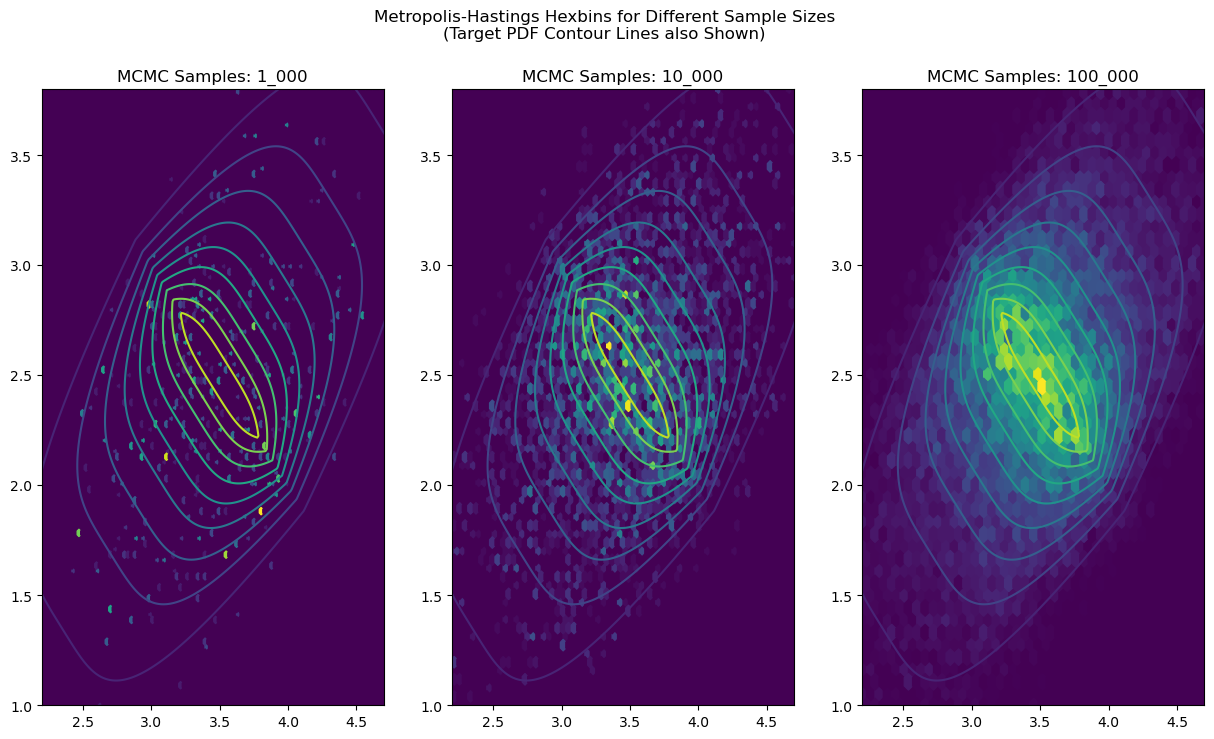

In [122]:
## MCMC path as heat map with target pdf superimposed
n_points = 500                                                                 
x = np.linspace(0, 6, n_points)                                                   
y = np.linspace(0, 5, n_points)                                                   
X, Y = np.meshgrid(x, y)                                                          
Z = hw8_pdf([X, Y])  # target pdf

fig, axs = plt.subplots(nrows=1, ncols=len(n_mcmc_samples), figsize=(15, 8))

for ix, (x_mcmc, y_mcmc) in enumerate(zip(x_mcmcs, y_mcmcs)):
    axs[ix].hexbin(x_mcmc, y_mcmc, label = "MCMC Simulation")
    axs[ix].contour(X, Y, Z, levels=10)  
    axs[ix].set_title(
        #f"Mean Acceptance Probability: {round(np.mean(acceptance_probabilities), 2)}"
        f"MCMC Samples: {n_mcmc_samples[ix]:_}")

# Manually setting limits 
axs[0].set_xlim(2.2, 4.7)
axs[0].set_ylim(1, 3.8)

axs[1].set_xlim(2.2, 4.7)
axs[1].set_ylim(1, 3.8)

axs[2].set_xlim(2.2, 4.7)
axs[2].set_ylim(1, 3.8)

# axs[1].set_xlim(1.5, 5)
# axs[1].set_ylim(0.5, 4.5)

# axs[2].set_xlim(1, 6)
# axs[2].set_ylim(0, 5)

fig.suptitle(
    "Metropolis-Hastings Hexbins for Different Sample Sizes\n(Target PDF Contour Lines also Shown)")

Text(0.5, 0.98, 'Rolling Mean of Metropolis-Hastings Samples of Different Sizes')

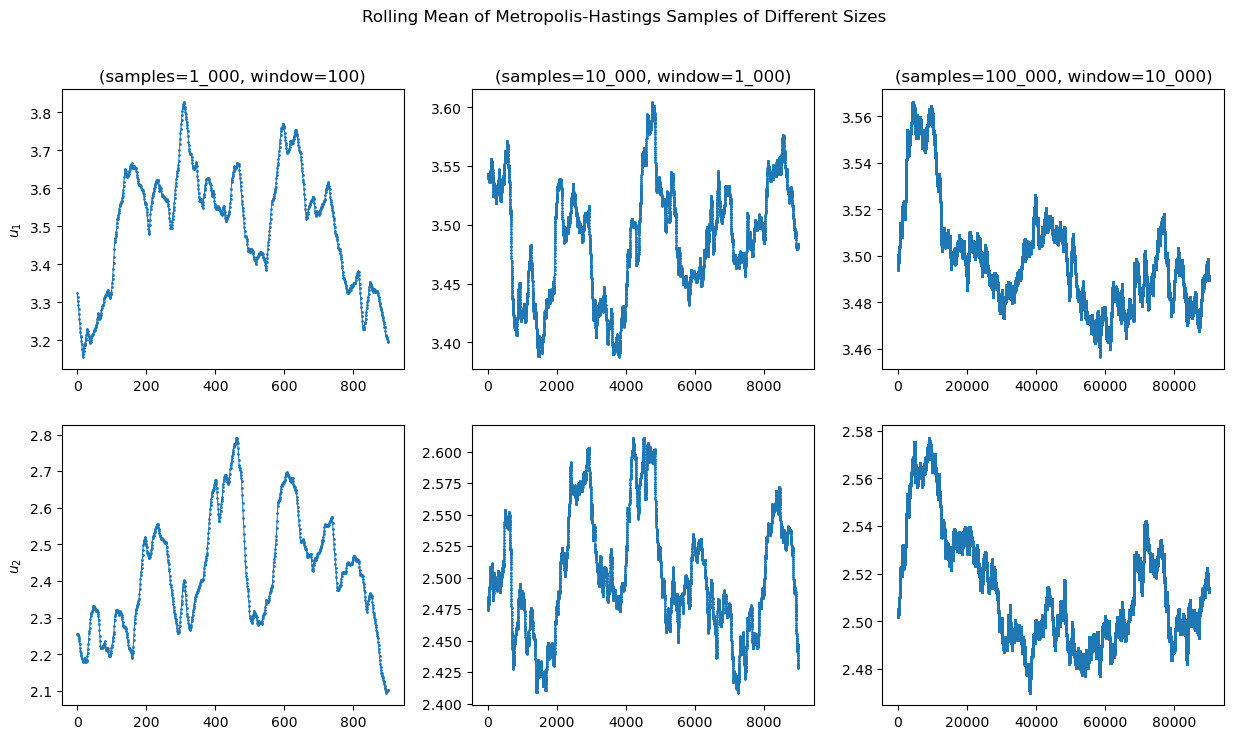

In [67]:
## The below plots shows how as the MCMC sample size increases,
## the magnitude of oscillations in the sampling points decreases
## (i.e., your sampling begins to stabilize around the target distribution)

# Compute rolling mean (aka, moving average, running mean) over some
# array x for a window size w
moving_average = lambda x, w: np.convolve(x, np.ones(w), "valid")/w

fig, axs = plt.subplots(nrows=2, ncols=len(n_mcmc_samples), figsize=(15, 8))

# iterate over MCMC samples, compute rolling means, and plot
for ix, (x_mcmc, y_mcmc) in enumerate(zip(x_mcmcs, y_mcmcs)):
    # compute rolling mean and use burnin size as window size
    x_mcmc_rolling_mean = moving_average(x_mcmc, burnins[ix])
    y_mcmc_rolling_mean = moving_average(y_mcmc, burnins[ix])
    t_points = range(len(x_mcmc_rolling_mean))

    axs[0, ix].plot(
        t_points, x_mcmc_rolling_mean, marker="o", markersize=1, linewidth=0.75)
    axs[0, ix].set_title(f"(samples={n_mcmc_samples[ix]:_}, window={burnins[ix]:_})")

    axs[1, ix].plot(
        t_points, y_mcmc_rolling_mean, marker="o", markersize=1, linewidth=0.75)

axs[0, 0].set_ylabel(r"$u_1$")
axs[1, 0].set_ylabel(r"$u_2$")
fig.suptitle(
    "Rolling Mean of Metropolis-Hastings Samples of Different Sizes") 

In [126]:
## NOTE: This is not complete.... and may not be necessary

## Compute the expectation of the PDF based on the MCMC sampling
expectations_mcmc = []
for (x_mcmc, y_mcmc) in zip(x_mcmcs, y_mcmcs):
    x_expectation = np.mean(x_mcmc)
    y_expectation = np.mean(y_mcmc)
    expectations_mcmc.append((x_expectation, y_expectation))

expectations_mcmc = np.array(expectations_mcmc)
display(expectations_mcmc)

## Attempting to compute expectation analytically??
## In principle, it would be nice to show that the 
## the MCMC converges to the true expectation...
## https://stats.stackexchange.com/questions/566645/expectation-of-a-multivariate-random-variable
x, y = (Indexed('x', i) for i in (0, 1))
V = Pow(x - y - 1, 4) + Abs(x + y - 6)
pdf = exp(-V)
joint_rv = JointRV('x', pdf)

# p(x)
marginal_px_expr = marginal_distribution(joint_rv, 0)
display(marginal_px_expr)

# p(y)
marginal_py_expr = marginal_distribution(joint_rv, 1)
display(marginal_py_expr)

array([[3.47907553, 2.39926875],
       [3.486684  , 2.49467578],
       [3.49718514, 2.510823  ]])

Lambda(x[0], exp(-1)*exp(4*x[0])*exp(-6*x[0]**2)*exp(4*x[0]**3)*exp(-x[0]**4)*Integral(exp(12*x[0]*x[1])*exp(12*x[0]*x[1]**2)*exp(4*x[0]*x[1]**3)*exp(-12*x[0]**2*x[1])*exp(-6*x[0]**2*x[1]**2)*exp(4*x[0]**3*x[1])*exp(-Abs(x[0] + x[1] - 6))*exp(-4*x[1])*exp(-6*x[1]**2)*exp(-4*x[1]**3)*exp(-x[1]**4), (x[1], -oo, oo)))

Lambda(x[1], exp(-1)*exp(-4*x[1])*exp(-6*x[1]**2)*exp(-4*x[1]**3)*exp(-x[1]**4)*Integral(exp(12*x[0]*x[1])*exp(12*x[0]*x[1]**2)*exp(4*x[0]*x[1]**3)*exp(-12*x[0]**2*x[1])*exp(-6*x[0]**2*x[1]**2)*exp(4*x[0]**3*x[1])*exp(-Abs(x[0] + x[1] - 6))*exp(4*x[0])*exp(-6*x[0]**2)*exp(4*x[0]**3)*exp(-x[0]**4), (x[0], -oo, oo)))